Visualize the hand landmarks etc. for a sample RPS video.

In [1]:
import cv2
import mediapipe as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [16]:
from matplotlib.patches import Patch

class FeatureVisualizer:
    def __init__(self):
        self.mp_hands = mp.solutions.hands
        self.hands = self.mp_hands.Hands(
            static_image_mode=False,
            max_num_hands=1,
            min_detection_confidence=0.5,
            min_tracking_confidence=0.5
        )
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles
        
        # Hand landmark names for better visualization
        self.landmark_names = [
            'WRIST', 'THUMB_CMC', 'THUMB_MCP', 'THUMB_IP', 'THUMB_TIP',
            'INDEX_FINGER_MCP', 'INDEX_FINGER_PIP', 'INDEX_FINGER_DIP', 'INDEX_FINGER_TIP',
            'MIDDLE_FINGER_MCP', 'MIDDLE_FINGER_PIP', 'MIDDLE_FINGER_DIP', 'MIDDLE_FINGER_TIP',
            'RING_FINGER_MCP', 'RING_FINGER_PIP', 'RING_FINGER_DIP', 'RING_FINGER_TIP',
            'PINKY_MCP', 'PINKY_PIP', 'PINKY_DIP', 'PINKY_TIP'
        ]
    
    def extract_landmarks_from_video(self, video_path, max_frames=30):
        """Extract hand landmarks from a video file"""
        cap = cv2.VideoCapture(video_path)
        landmarks_sequence = []
        frames_with_landmarks = []
        frame_count = 0
        
        while frame_count < max_frames:
            ret, frame = cap.read()
            if not ret:
                break
                
            # Convert BGR to RGB
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            # Process frame
            results = self.hands.process(rgb_frame)
            
            if results.multi_hand_landmarks:
                # Get first hand landmarks
                hand_landmarks = results.multi_hand_landmarks[0]
                
                # Extract x, y, z coordinates
                landmarks = []
                for lm in hand_landmarks.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
                
                landmarks_sequence.append(landmarks)
                frames_with_landmarks.append(frame)
            
            frame_count += 1
        
        cap.release()
        print("Frame count:", frame_count)
        
        # (frames, landmark x xyz coordinates), frames_with_landmarks
        return np.array(landmarks_sequence), frames_with_landmarks
    
    def normalize_landmarks(self, landmarks):
        """Normalize landmarks relative to wrist position"""
        if len(landmarks) == 0:
            return landmarks
            
        normalized = landmarks.copy()
        
        for i in range(len(landmarks)):
            # Reshape to get individual landmarks
            frame_landmarks = landmarks[i].reshape(21, 3)
            
            # Get wrist position (landmark 0)
            wrist = frame_landmarks[0]
            
            # Subtract wrist position from all landmarks
            frame_landmarks = frame_landmarks - wrist
            
            # Calculate hand size (distance from wrist to middle finger tip)
            hand_size = np.linalg.norm(frame_landmarks[12])  # Middle finger tip
            
            # Normalize by hand size (avoid division by zero)
            if hand_size > 0:
                frame_landmarks = frame_landmarks / hand_size
            
            normalized[i] = frame_landmarks.flatten()
        
        return normalized

    def visualize_features_separately(self, video_path, gesture_name="Unknown"):
        """Visualize features extracted from a video with each analysis as a separate plot"""
        print(f"Analyzing video: {video_path}")
        print(f"Gesture: {gesture_name}")
        
        # Extract landmarks
        landmarks_raw, frames = self.extract_landmarks_from_video(video_path)
        
        if len(landmarks_raw) == 0:
            print("No hand landmarks detected in the video!")
            return
        
        print(f"Extracted {len(landmarks_raw)} frames with hand landmarks")
        
        # Normalize landmarks
        landmarks_normalized = self.normalize_landmarks(landmarks_raw)

        self._plot_sample_frames(frames, landmarks_raw, gesture_name)

        self._plot_3d_landmarks(landmarks_normalized, gesture_name)

        self._plot_feature_evolution(landmarks_normalized, gesture_name)

        self._plot_hand_span_distribution(landmarks_normalized, gesture_name)

        self._plot_landmark_variance(landmarks_normalized, gesture_name)

        self._plot_correlation_heatmap(landmarks_normalized, gesture_name)

    def _plot_sample_frames(self, frames, landmarks_raw, gesture_name):
        """Plot sample frames with landmarks overlaid"""
        fig, axes = plt.subplots(1, 4, figsize=(16, 4))
        fig.suptitle(f'Sample Frames with Landmarks - {gesture_name}', fontsize=14)
        
        #frame_indices = [14, 19, 24, 29] if len(frames) >= 29 else list(range(min(4, len(frames))))
        frame_indices = [14, 19, 24, 29] #if len(frames) >= 29 else list(range(min(4, len(frames))))
        
        for i, (ax, frame_idx) in enumerate(zip(axes, frame_indices)):
            if frame_idx < len(frames):
                print(f"Plotting frame {frame_idx+1} for gesture {gesture_name}")
                frame_rgb = cv2.cvtColor(frames[frame_idx], cv2.COLOR_BGR2RGB)
                ax.imshow(frame_rgb)
                ax.set_title(f'Frame {frame_idx+1}')
                ax.axis('off')
                
                # Draw landmarks
                landmarks_2d = landmarks_raw[frame_idx].reshape(21, 3)[:, :2]
                h, w = frame_rgb.shape[:2]
                landmarks_2d[:, 0] *= w
                landmarks_2d[:, 1] *= h
                
                ax.scatter(landmarks_2d[:, 0], landmarks_2d[:, 1], c='red', s=30, alpha=0.8)
                
                # Draw connections
                connections = [
                    (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
                    (0, 5), (5, 6), (6, 7), (7, 8),  # Index
                    (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
                    (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
                    (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
                ]
                
                for start, end in connections:
                    ax.plot([landmarks_2d[start, 0], landmarks_2d[end, 0]], 
                        [landmarks_2d[start, 1], landmarks_2d[end, 1]], 
                        'b-', linewidth=2, alpha=0.7)
        
        plt.tight_layout()
        plt.show()

    def _plot_3d_landmarks(self, landmarks_normalized, gesture_name):
        """Plot 3D visualization of normalized landmarks"""
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        
        # Average landmarks across all frames
        avg_landmarks = np.mean(landmarks_normalized, axis=0).reshape(21, 3)
        
        # Plot 3D landmarks
        ax.scatter(avg_landmarks[:, 0], avg_landmarks[:, 1], avg_landmarks[:, 2], 
                c='red', s=50)
        
        # Draw connections
        connections = [
            (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
            (0, 5), (5, 6), (6, 7), (7, 8),  # Index
            (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
            (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
            (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
        ]
        
        for start, end in connections:
            ax.plot([avg_landmarks[start, 0], avg_landmarks[end, 0]], 
                [avg_landmarks[start, 1], avg_landmarks[end, 1]], 
                [avg_landmarks[start, 2], avg_landmarks[end, 2]], 
                'b-', linewidth=2)
        
        ax.set_title(f'3D Normalized Landmarks - {gesture_name}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
        plt.show()

    def _plot_feature_evolution(self, landmarks_normalized, gesture_name):
        """Plot feature evolution over time (X-coordinate)"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        key_landmarks = [4, 8, 12, 16, 20]  # Fingertips
        key_names = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']
        
        for landmark_idx, name in zip(key_landmarks, key_names):
            x_coords = landmarks_normalized[:, landmark_idx*3]  # X coordinate
            ax.plot(x_coords, label=f'{name} tip', linewidth=2)
        
        ax.set_title(f'Fingertip X-coordinates Over Time - {gesture_name}')
        ax.set_xlabel('Frame')
        ax.set_ylabel('Normalized Y coordinate')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plt.show()

    def _plot_hand_span_distribution(self, landmarks_normalized, gesture_name):
        """Plot hand span distribution"""
        fig, ax = plt.subplots(figsize=(10, 6))
        
        thumb_tip = landmarks_normalized[:, 4*3:4*3+3]  # Landmark 4
        pinky_tip = landmarks_normalized[:, 20*3:20*3+3]  # Landmark 20
        hand_spans = np.linalg.norm(thumb_tip - pinky_tip, axis=1)
        
        ax.hist(hand_spans, bins=10, alpha=0.7, edgecolor='black')
        ax.set_title(f'Hand Span Distribution - {gesture_name}')
        ax.set_xlabel('Normalized Hand Span')
        ax.set_ylabel('Frequency')
        ax.grid(True, alpha=0.3)
        plt.show()

    def _plot_landmark_variance(self, landmarks_normalized, gesture_name):
        """Plot landmark movement variance"""
        fig, ax = plt.subplots(figsize=(12, 6))
        
        landmark_variance = np.var(landmarks_normalized.reshape(-1, 21, 3), axis=0)
        total_variance = np.sum(landmark_variance, axis=1)
        
        bars = ax.bar(range(21), total_variance, alpha=0.7)
        ax.set_title(f'Landmark Movement Variance - {gesture_name}')
        ax.set_xlabel('Landmark Index')
        ax.set_ylabel('Total Variance')
        # ax.set_xticks(range(0, 21, 2))
        # ax.set_xticklabels(self.landmark_names[::2], rotation=45, ha='right')
        ax.set_xticks(range(0, 21, 1))
        ax.set_xticklabels(self.landmark_names, rotation=45, ha='right')
        # Color bars by finger
        finger_colors = ['red', 'orange', 'orange', 'orange', 'orange',  # Thumb
                        'green', 'green', 'green', 'green',  # Index
                        'blue', 'blue', 'blue', 'blue',  # Middle
                        'purple', 'purple', 'purple', 'purple',  # Ring
                        'brown', 'brown', 'brown', 'brown']  # Pinky
        
        for bar, color in zip(bars, finger_colors):
            bar.set_color(color)
        
        # Add legend for fingers
        legend_elements = [
            Patch(facecolor='red', label='Thumb'),
            Patch(facecolor='green', label='Index'),
            Patch(facecolor='blue', label='Middle'),
            Patch(facecolor='purple', label='Ring'),
            Patch(facecolor='brown', label='Pinky'),]
        ax.legend(handles=legend_elements, title='Finger')
        
        plt.show()

    def _plot_correlation_heatmap(self, landmarks_normalized, gesture_name):
        """Plot feature correlation heatmap"""
        fig, ax = plt.subplots(figsize=(10, 8))
        
        # Calculate correlation matrix for fingertip coordinates
        fingertip_features = landmarks_normalized[:, [4*3, 4*3+1, 4*3+2,  # Thumb
                                                    8*3, 8*3+1, 8*3+2,  # Index
                                                    12*3, 12*3+1, 12*3+2,  # Middle
                                                    16*3, 16*3+1, 16*3+2,  # Ring
                                                    20*3, 20*3+1, 20*3+2]]  # Pinky
        
        corr_matrix = np.corrcoef(fingertip_features.T)
        im = ax.imshow(corr_matrix, cmap='coolwarm', aspect='auto')
        ax.set_title(f'Fingertip Feature Correlation - {gesture_name}')
        
        # Add labels
        labels = ['Th_X', 'Th_Y', 'Th_Z', 'Id_X', 'Id_Y', 'Id_Z', 
                'Md_X', 'Md_Y', 'Md_Z', 'Rg_X', 'Rg_Y', 'Rg_Z', 
                'Pk_X', 'Pk_Y', 'Pk_Z']
        ax.set_xticks(range(len(labels)))
        ax.set_yticks(range(len(labels)))
        ax.set_xticklabels(labels, rotation=45, ha='right')
        ax.set_yticklabels(labels)
        
        plt.colorbar(im, ax=ax, shrink=0.8)
        plt.tight_layout()
        plt.show()

Analyzing video: /Users/christina/code/RockPaperScissors/my_rps_dataset/data/scissors/scissors_16.avi
Gesture: Scissors


I0000 00:00:1752959537.023754  456503 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1752959537.028732  458131 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1752959537.033570  458137 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/christina/code/RockPaperScissors/rps_venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Frame count: 30
Extracted 30 frames with hand landmarks
Plotting frame 15 for gesture Scissors
Plotting frame 20 for gesture Scissors
Plotting frame 25 for gesture Scissors
Plotting frame 30 for gesture Scissors


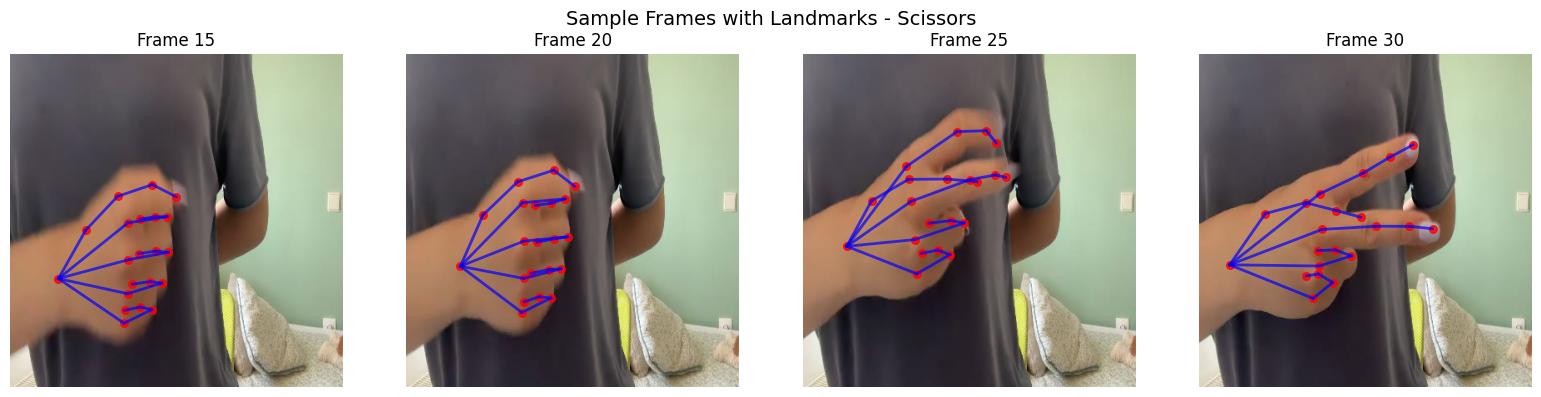

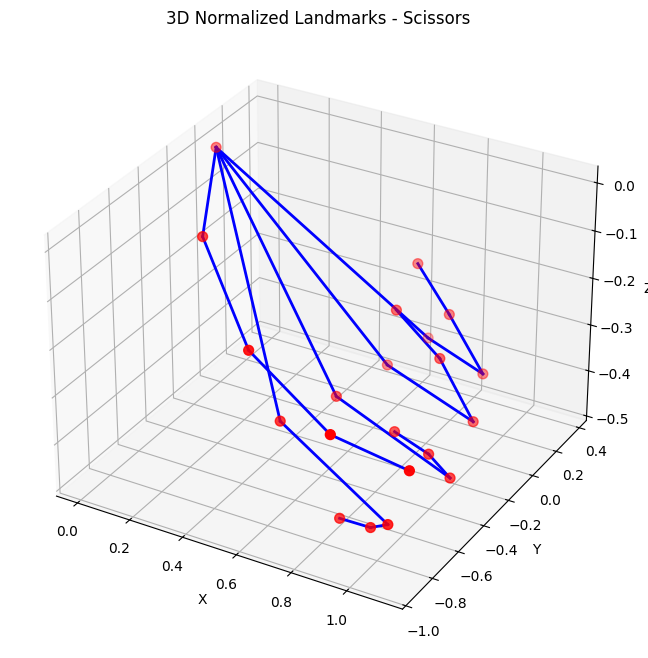

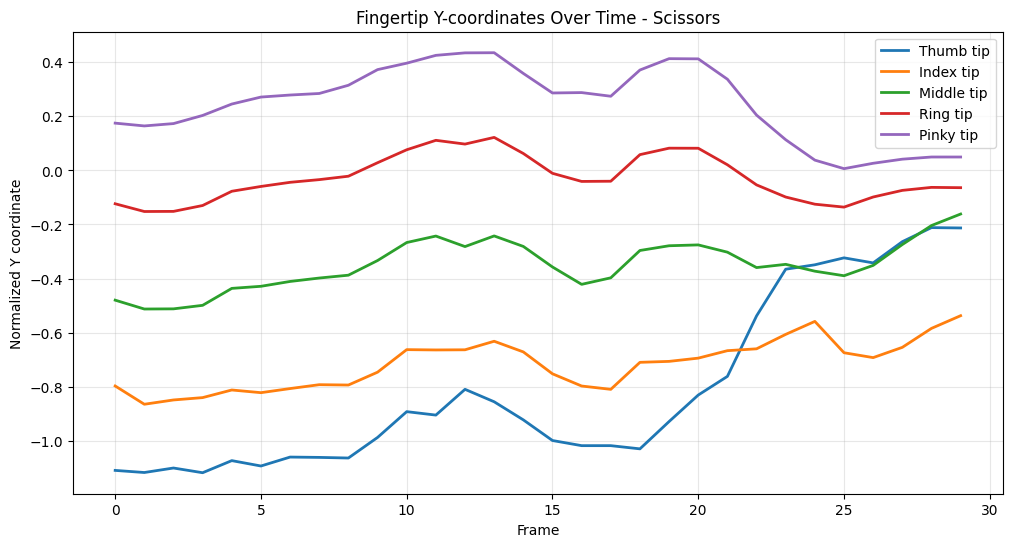

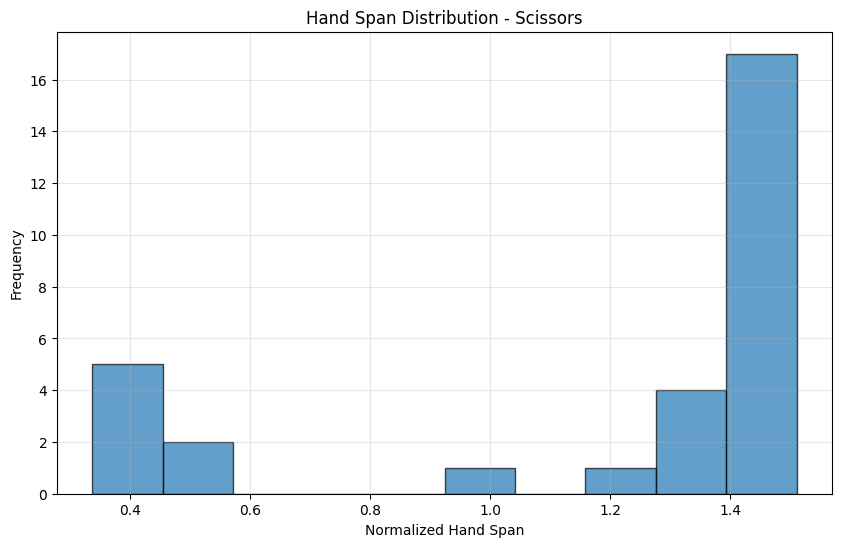

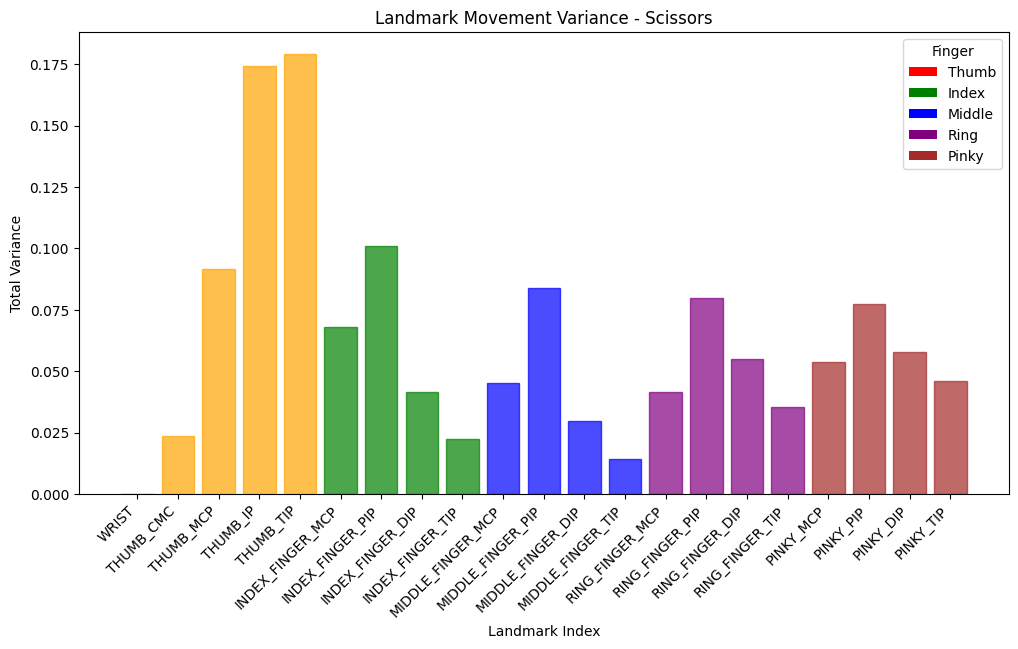

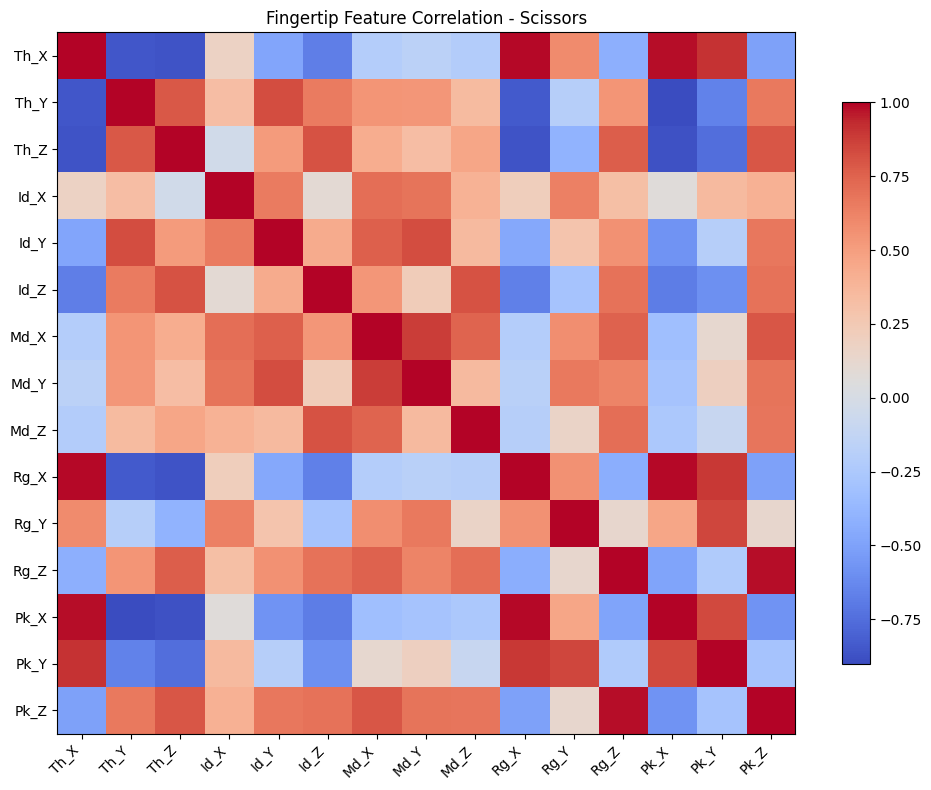

In [8]:
visualizer = FeatureVisualizer()
gesture_name = "Scissors"
# video_path = f"/Users/christina/code/RockPaperScissors/my_rps_dataset/data/{gesture_name.lower()}/{gesture_name.lower()}_15.avi"
video_path = f"/Users/christina/code/RockPaperScissors/my_rps_dataset/data/{gesture_name.lower()}/{gesture_name.lower()}_16.avi" 
# video_path = f"/Users/christina/code/RockPaperScissors/my_rps_dataset/data/{gesture_name.lower()}/{gesture_name.lower()}_24.avi" 
visualizer.visualize_features_separately(video_path, gesture_name)

Analyzing video: /Users/christina/code/RockPaperScissors/my_rps_dataset/data/scissors/scissors_36.avi
Gesture: Scissors


I0000 00:00:1753211751.726986  163765 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1753211751.733235  311969 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753211751.740307  311972 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/christina/code/RockPaperScissors/rps_venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Frame count: 30
Extracted 30 frames with hand landmarks
Plotting frame 15 for gesture Scissors
Plotting frame 20 for gesture Scissors
Plotting frame 25 for gesture Scissors
Plotting frame 30 for gesture Scissors


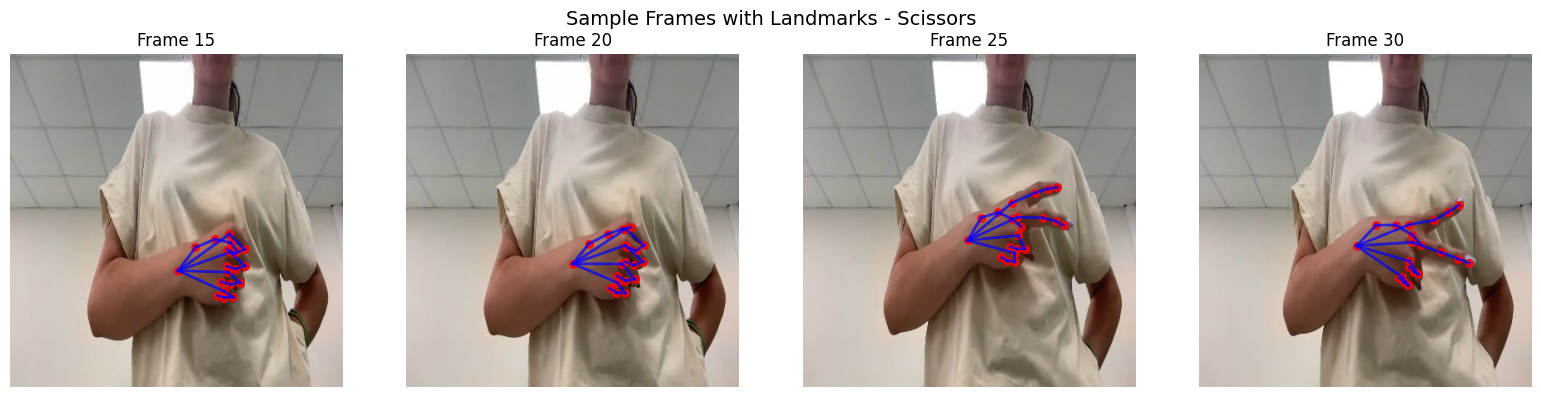

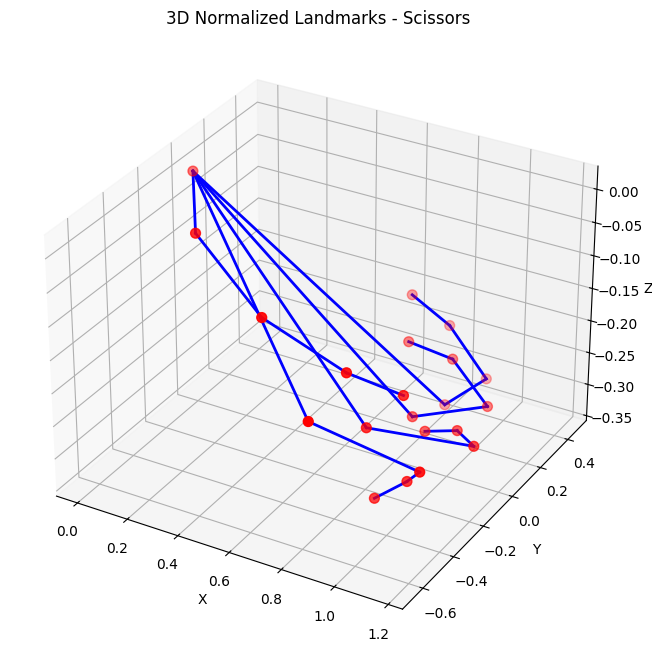

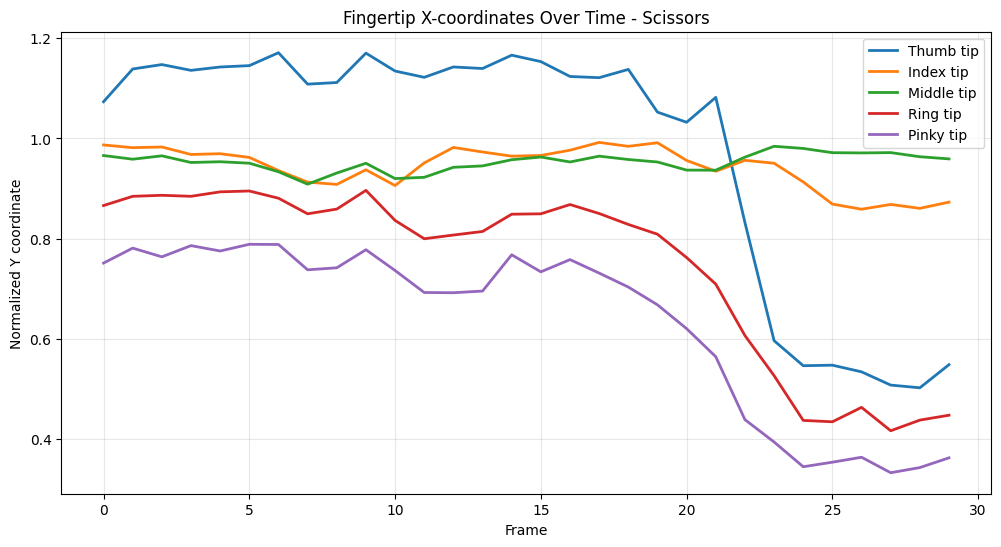

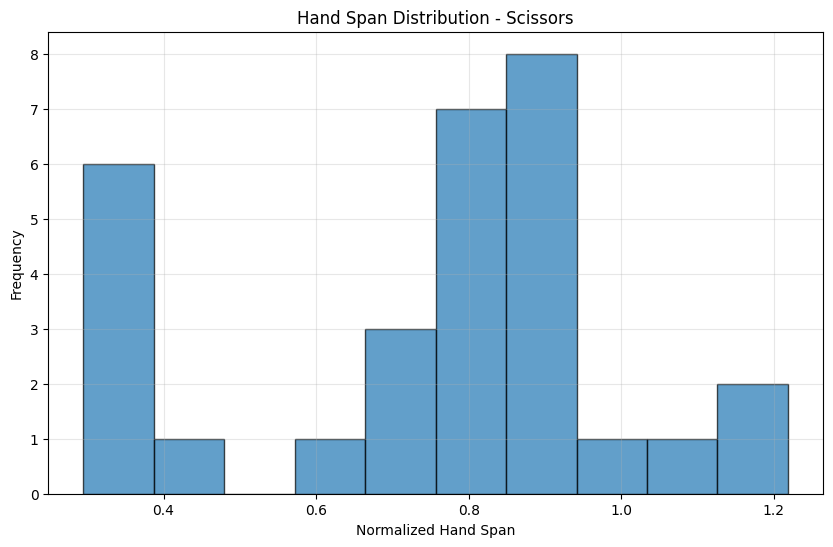

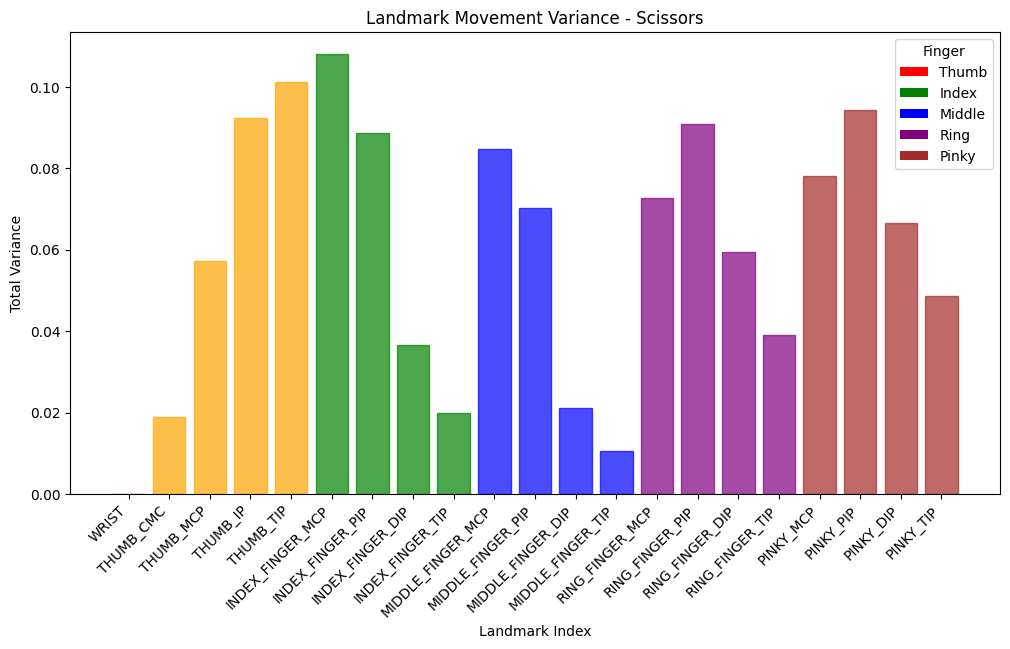

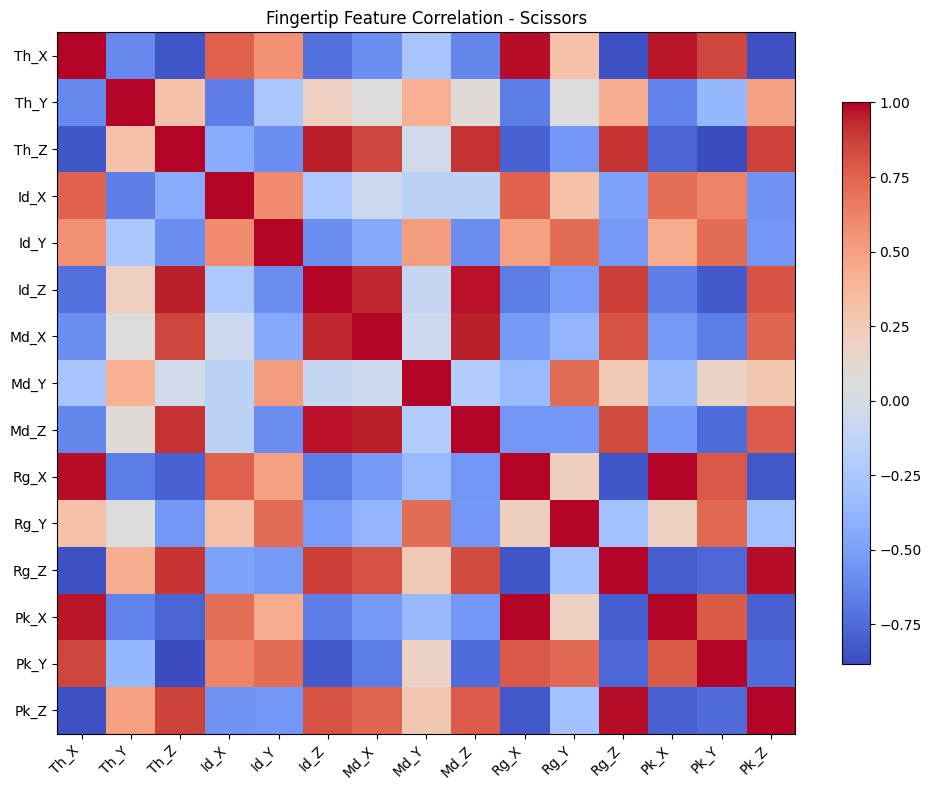

In [17]:
visualizer = FeatureVisualizer()
gesture_name = "Scissors"
video_path = f"/Users/christina/code/RockPaperScissors/my_rps_dataset/data/{gesture_name.lower()}/{gesture_name.lower()}_36.avi" 
visualizer.visualize_features_separately(video_path, gesture_name)

Analyzing video: /Users/christina/code/RockPaperScissors/my_rps_dataset/data/paper/paper_37.avi
Gesture: Paper


I0000 00:00:1753211829.045384  163765 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1753211829.051511  312848 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753211829.057911  312852 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/christina/code/RockPaperScissors/rps_venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Frame count: 30
Extracted 30 frames with hand landmarks
Plotting frame 15 for gesture Paper
Plotting frame 20 for gesture Paper
Plotting frame 25 for gesture Paper
Plotting frame 30 for gesture Paper


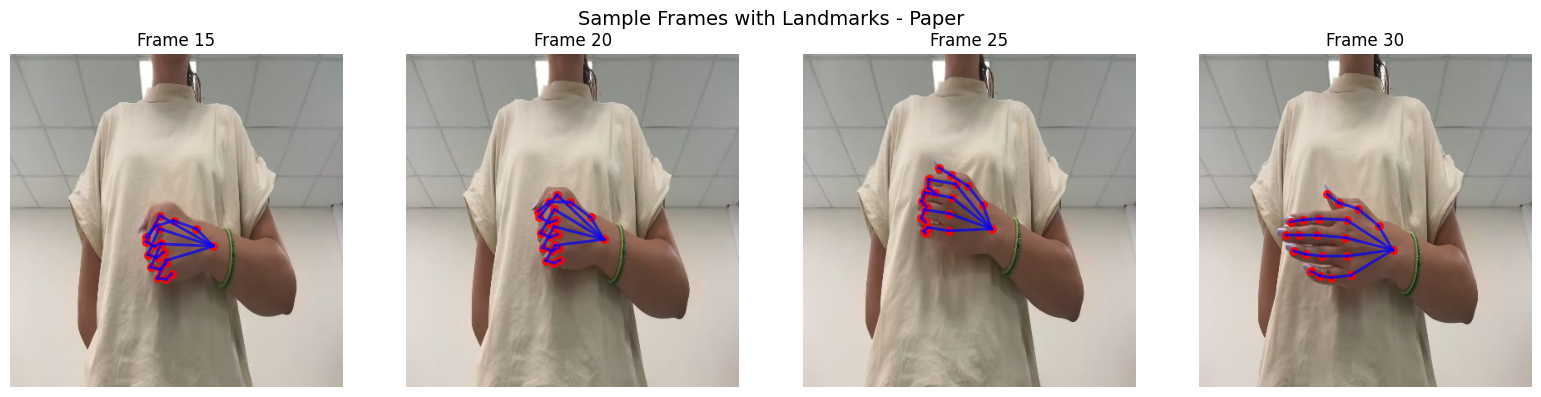

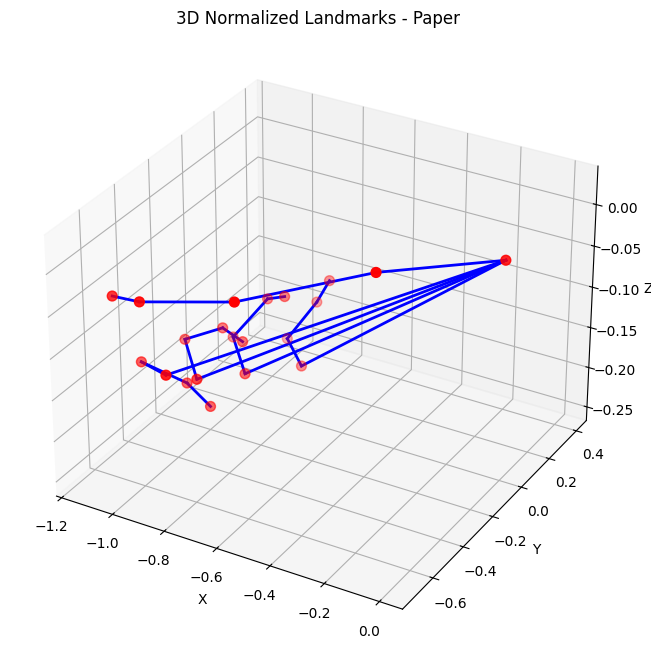

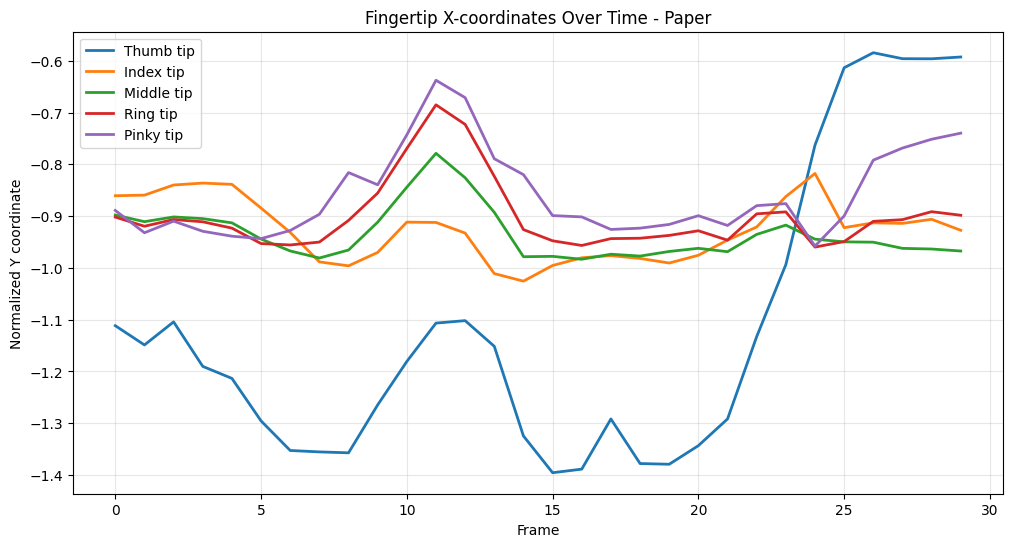

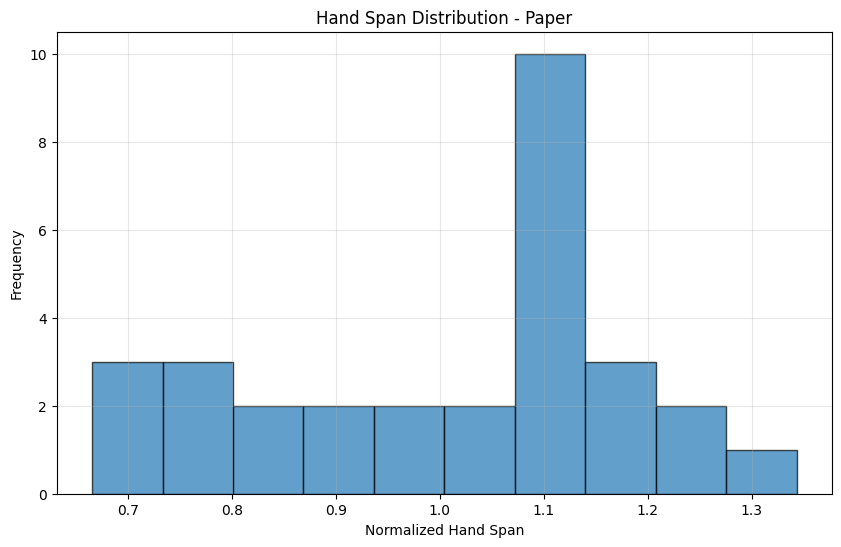

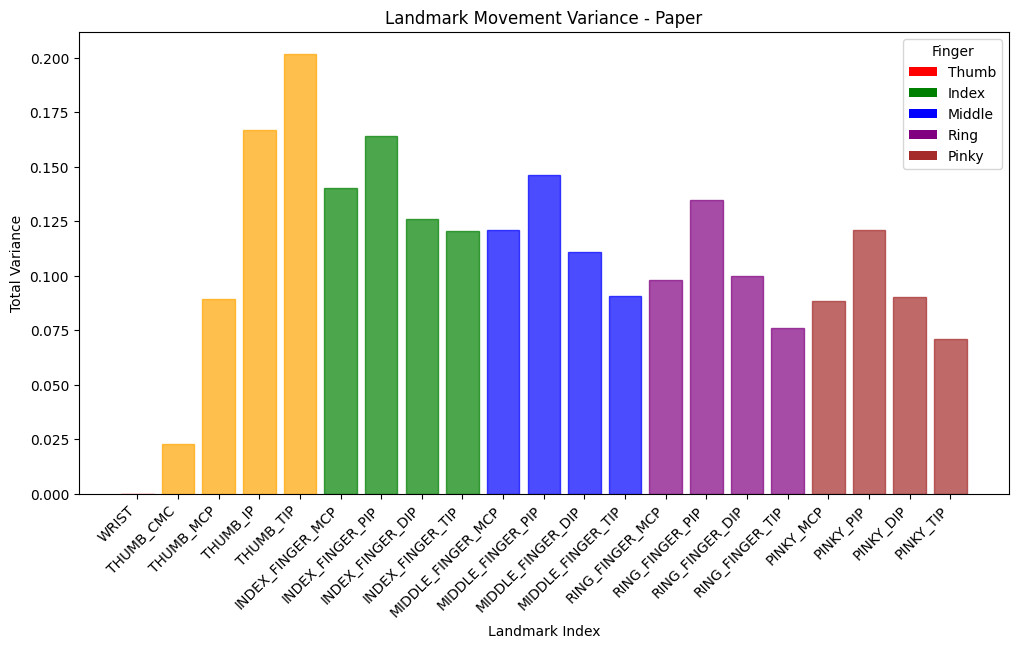

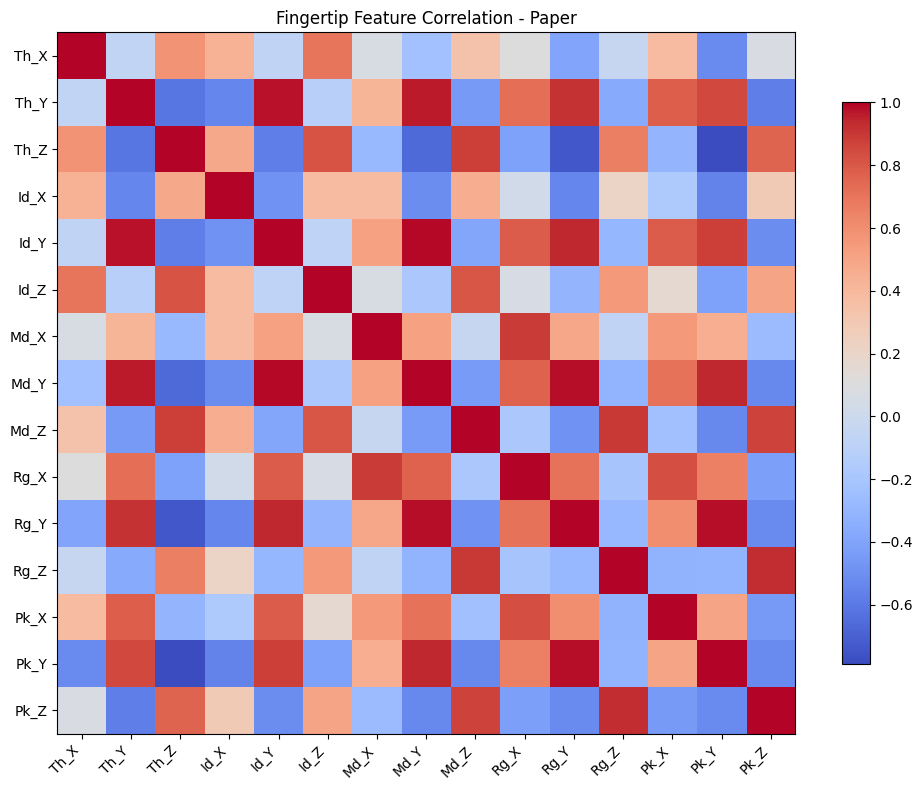

In [20]:
visualizer = FeatureVisualizer()
gesture_name = "Paper"
video_path = f"/Users/christina/code/RockPaperScissors/my_rps_dataset/data/{gesture_name.lower()}/{gesture_name.lower()}_37.avi" 
visualizer.visualize_features_separately(video_path, gesture_name)

I0000 00:00:1753211896.488181  163765 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1753211896.492795  314224 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753211896.497242  314229 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/christina/code/RockPaperScissors/rps_venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Analyzing video: /Users/christina/code/RockPaperScissors/my_rps_dataset/data/rock/rock_33.avi
Gesture: Rock
Frame count: 30
Extracted 30 frames with hand landmarks
Plotting frame 15 for gesture Rock
Plotting frame 20 for gesture Rock
Plotting frame 25 for gesture Rock
Plotting frame 30 for gesture Rock


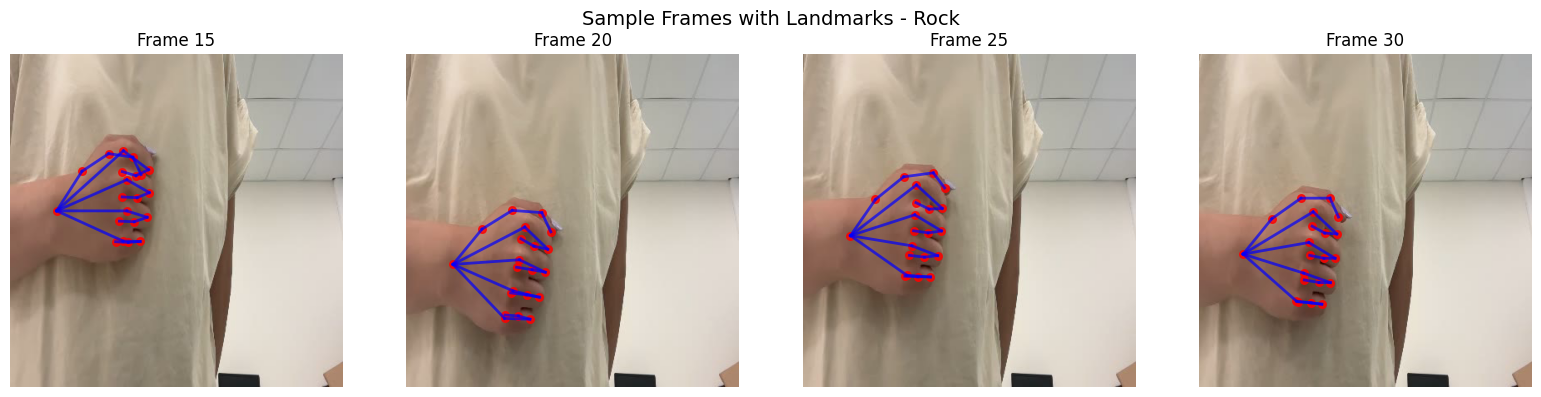

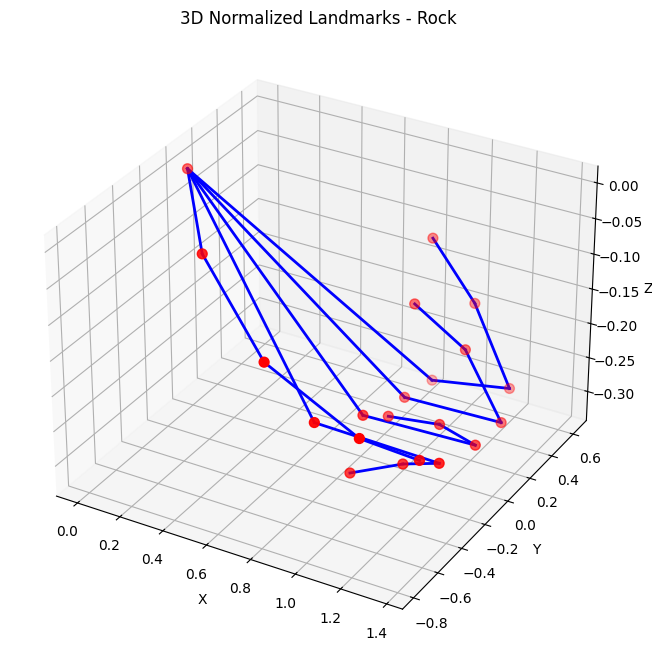

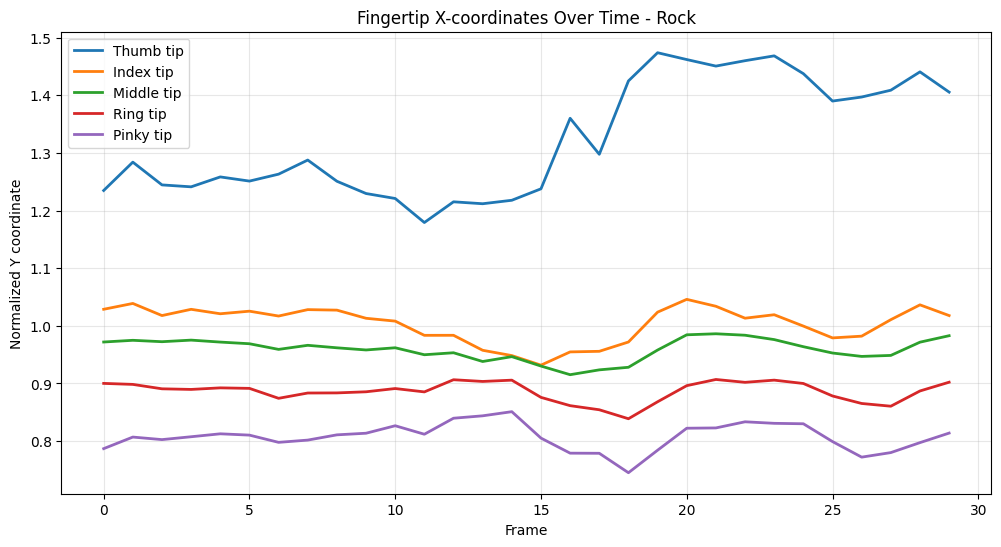

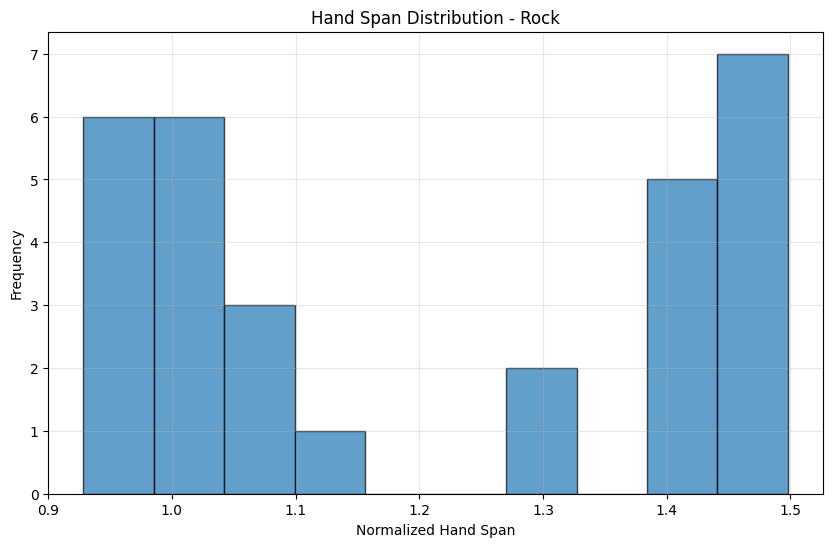

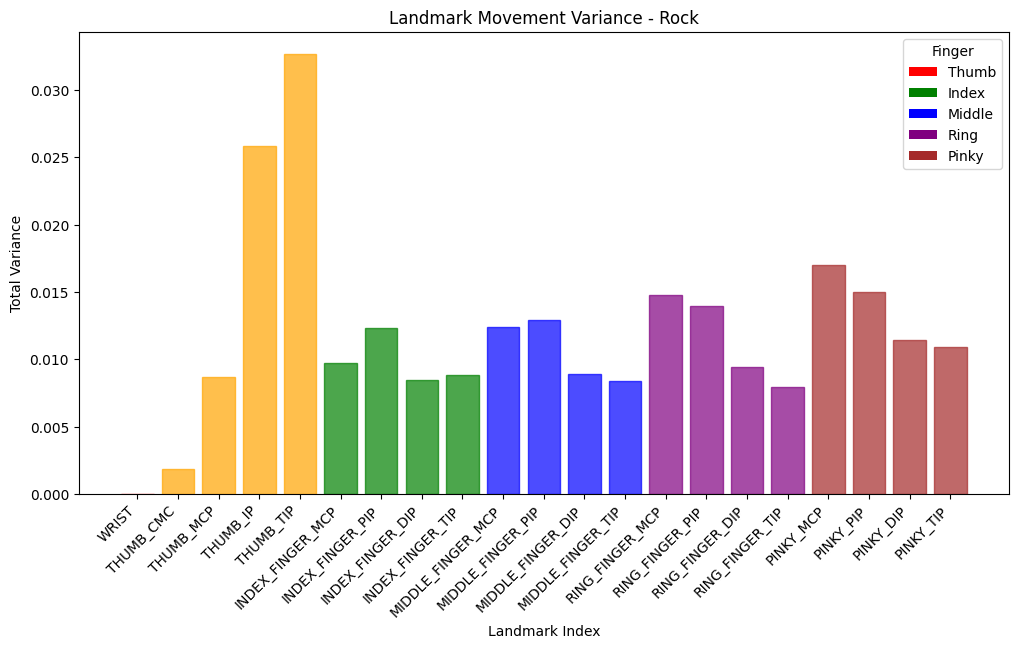

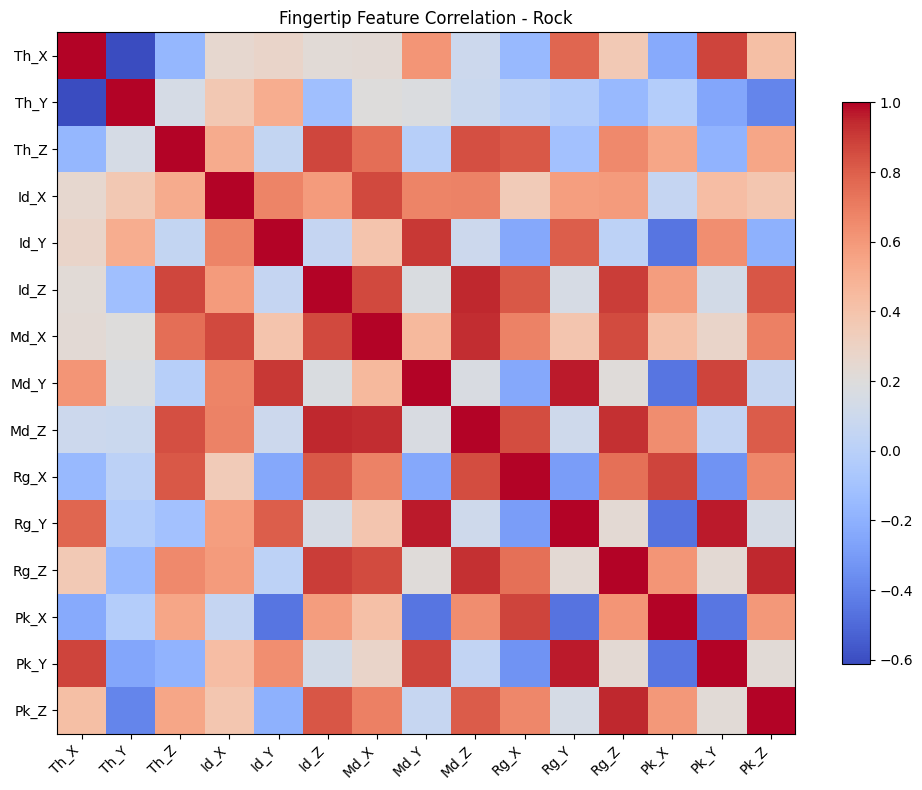

In [24]:
visualizer = FeatureVisualizer()
gesture_name = "Rock"
video_path = f"/Users/christina/code/RockPaperScissors/my_rps_dataset/data/{gesture_name.lower()}/{gesture_name.lower()}_33.avi" 
visualizer.visualize_features_separately(video_path, gesture_name)

Analyzing video: /Users/christina/code/RockPaperScissors/my_rps_dataset/data/scissors/scissors_34.avi
Gesture: Scissors


I0000 00:00:1753216747.634719  163765 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M3 Pro
W0000 00:00:1753216747.642480  368282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1753216747.648365  368282 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
/Users/christina/code/RockPaperScissors/rps_venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Frame count: 30
Extracted 30 frames with hand landmarks
Plotting frame 15 for gesture Scissors
Plotting frame 20 for gesture Scissors
Plotting frame 25 for gesture Scissors
Plotting frame 30 for gesture Scissors


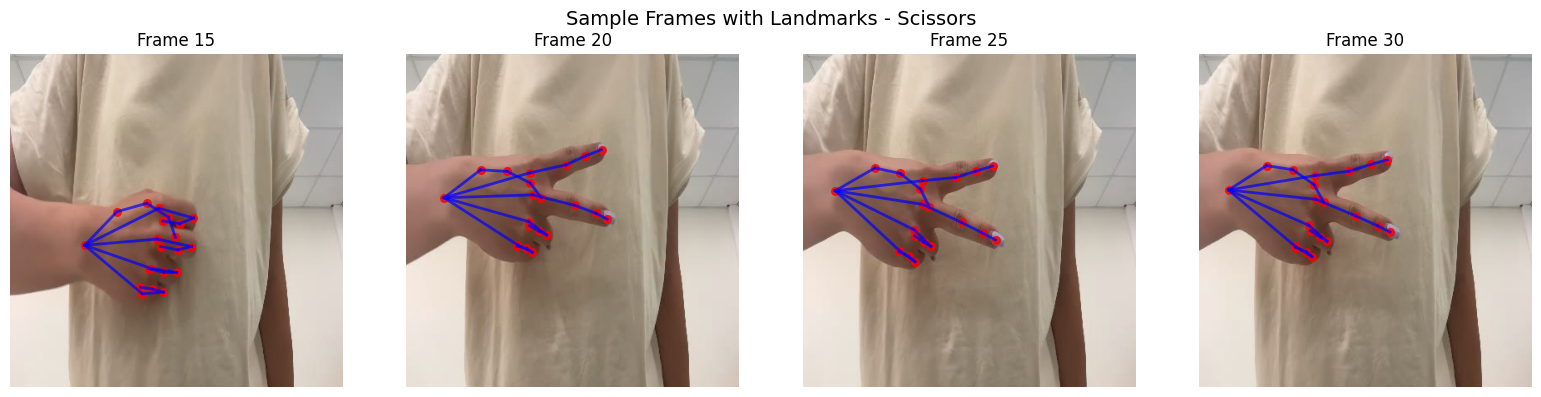

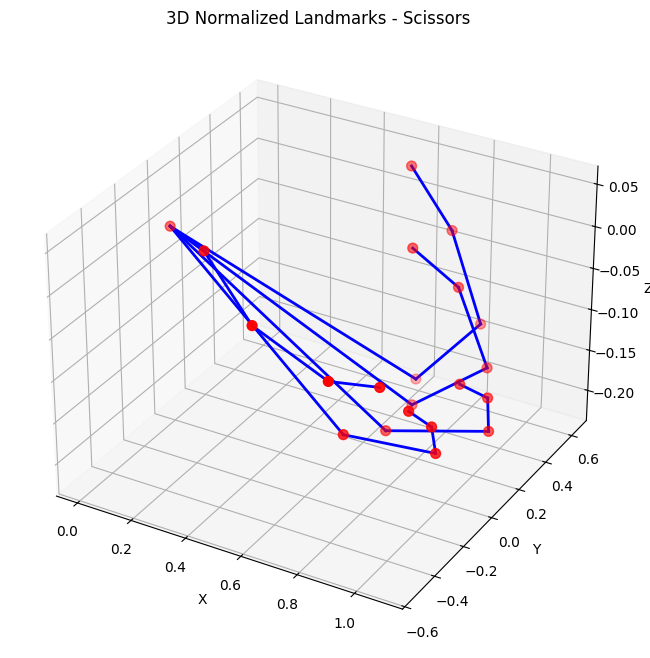

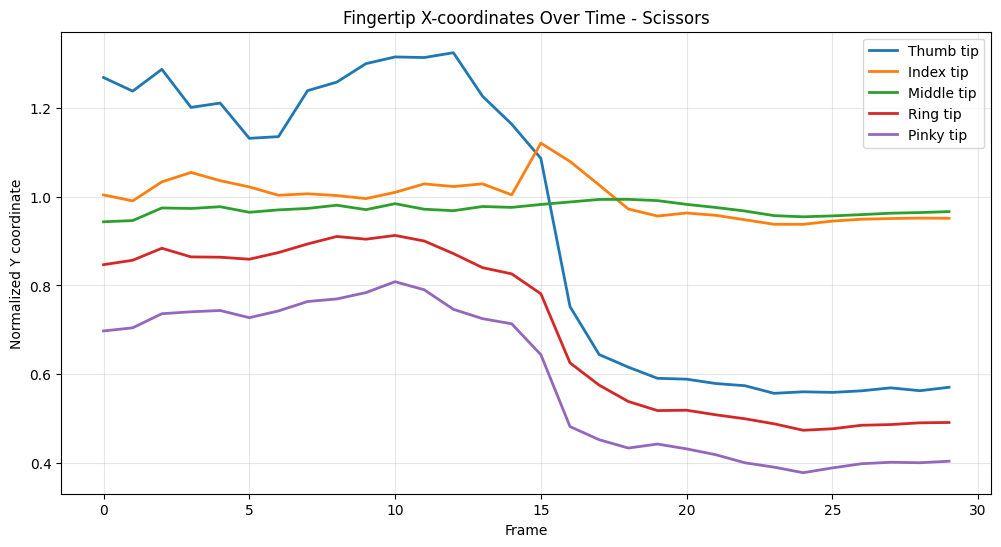

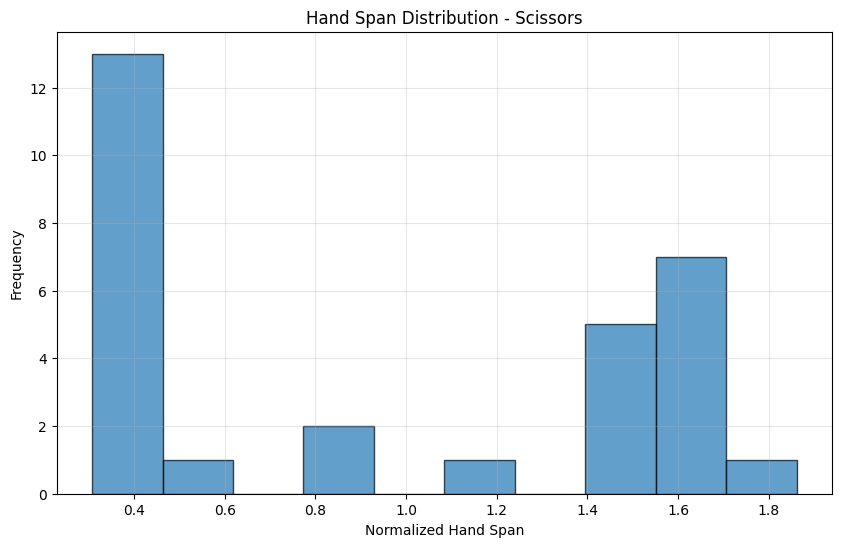

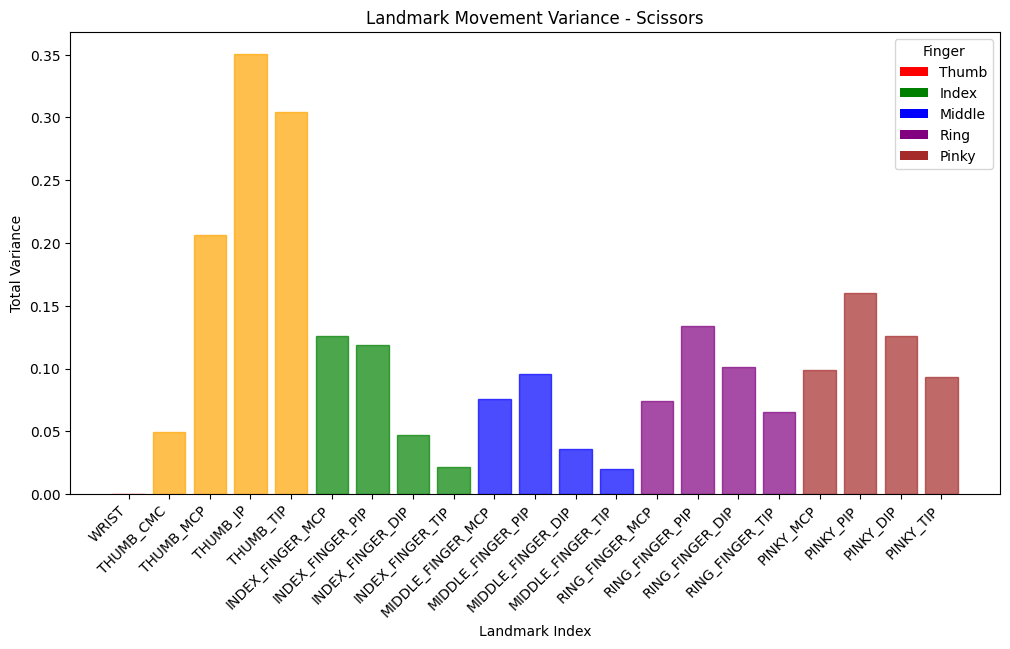

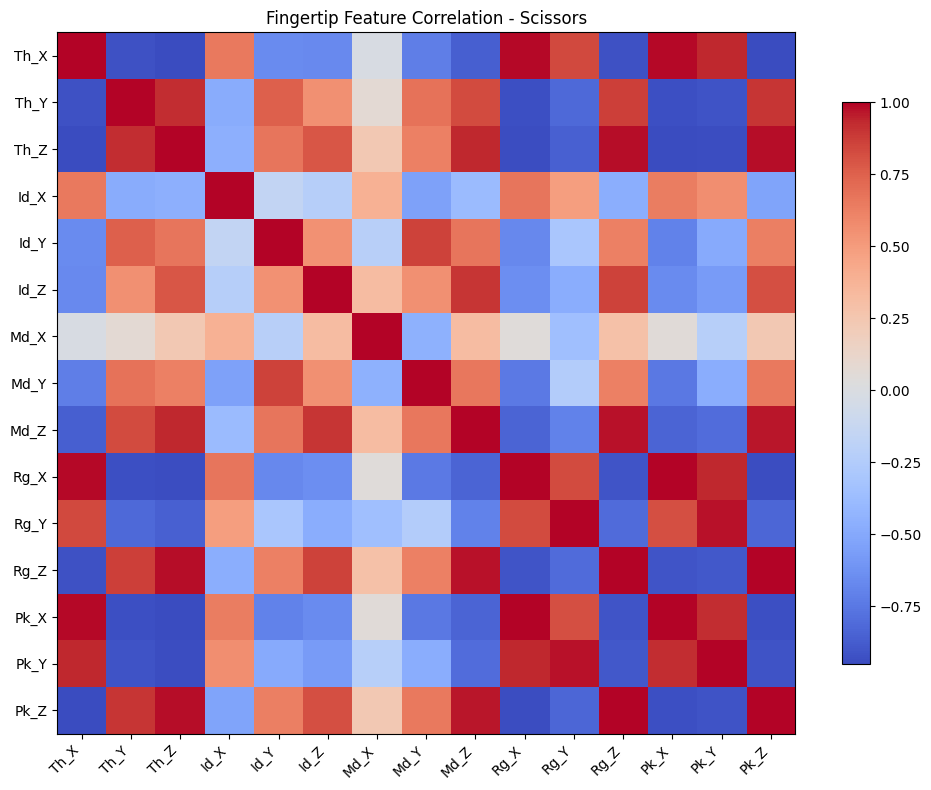

In [28]:
visualizer = FeatureVisualizer()
gesture_name = "Scissors"
video_path = f"/Users/christina/code/RockPaperScissors/my_rps_dataset/data/{gesture_name.lower()}/{gesture_name.lower()}_34.avi" 
visualizer.visualize_features_separately(video_path, gesture_name)